# Import Library

In [ ]:
!pip install nltk
!pip install textblob
!pip install wordcloud

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix

# Import Dataset

In [ ]:
df = pd.read_csv("Emotion_classify_Data.csv")

In [ ]:
# Melihat 5 data pertama

df.head()

,Comment,Emotion
0,i seriously hate one subject to death but now i feel reluctant to drop it,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feelings and i think that i am afraid to accept the possibility that he might not make it,fear
3,ive been really angry with r and i feel like an idiot for trusting him in the first place,joy
4,i feel suspicious if there is no one outside like the rapture has happened or something,fear


In [ ]:
# Melihat informasi dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5937 entries, 0 to 5936
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  5937 non-null   object
 1   Emotion  5937 non-null   object
dtypes: object(2)
memory usage: 92.9+ KB


In [ ]:
# Cek apakah ada data duplikat

df.duplicated().sum()

0

In [ ]:
# Melihat nilai unik pada kolom 'Emotion'

df['Emotion'].unique()

array(['fear', 'anger', 'joy'], dtype=object)

# Text Preprocessing

In [ ]:
# Melihat panjang text sebelum dilakukan preprocessing

print("after text preprocessing len: ",len(df["Comment"][0]))

after text preprocessing len:  73


In [ ]:
# Menghapus Stopwords (a, an, and, as, at, but, by, for, if, is, it, on, of, or, s, that, their, the, then, these ...)

nltk.download('stopwords')
sw = stopwords.words('english')

df["Comment"] = df["Comment"].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# menghapus kata-kata yang jarang muncul

# Pada kali ini, mencoba menghapus kata kata yang hanya muncul <= 1
temp_Context = pd.Series(' '.join(df['Comment']).split()).value_counts()
drops = temp_Context[temp_Context <= 1]
df['Comment'] = df['Comment'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))

In [ ]:
# Tokenization

nltk.download('punkt')
df["Comment"].apply(lambda x: TextBlob(x).words).head(1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0    [seriously, hate, one, subject, death, feel, reluctant, drop]
Name: Comment, dtype: object

In [ ]:
# Lemmatization

nltk.download('wordnet')
df["Comment"] = df["Comment"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Mengubah teks menjadi matriks fitur menggunakan TF-IDF
vectorizer = TfidfVectorizer()
X_vect = vectorizer.fit_transform(df['Comment'])

In [ ]:
# Melihat panjang text setelah dilakukan preprocessing

print("after text preprocessing len: ",len(df["Comment"][0]))

after text preprocessing len:  52


# Exploratory Data Analysis

In [ ]:
# Menghitung banyaknya kata yang muncul pada seluruh kalimat pada kolom "Context"

tf_Context = df["Comment"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf_Context.columns = ["words", "tf"]
tf_Context.sort_values("tf", ascending=False)

,words,tf
5,feel,4165.00
16,feeling,2068.00
27,like,994.00
8,im,943.00
156,time,356.00
...,...,...
2552,income,2.00
2551,skinny,2.00
2548,dollar,2.00
3554,intellectual,2.00


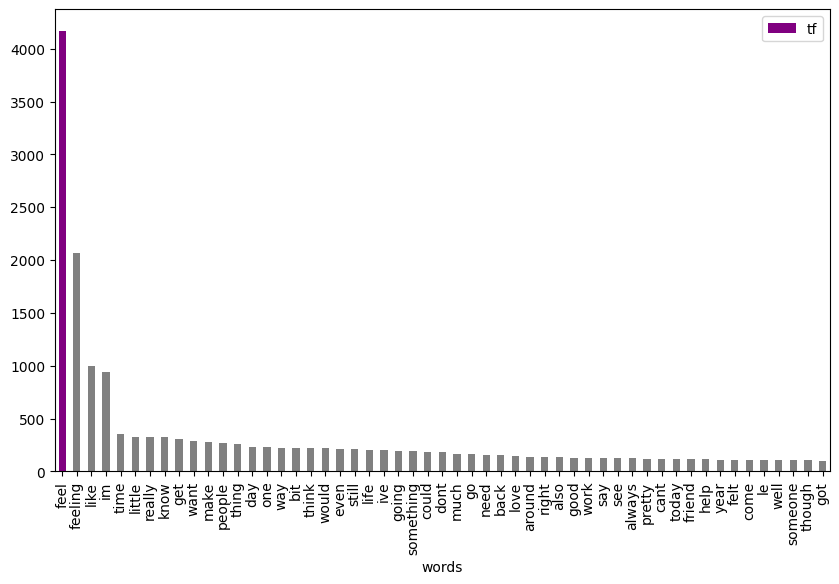

In [ ]:
# Barplot untuk Context


plt.figure(figsize=(10, 6))

# Mengurutkan data berdasarkan nilai tf
sorted_data = tf_Context[tf_Context["tf"] > 100].sort_values(by="tf", ascending=False)

# Mendefinisikan warna
colors = ['grey' if i != 0 else 'purple' for i in range(len(sorted_data))]

# Plot barplot dengan warna yang berbeda
sorted_data.plot.bar(x="words", y="tf", color=colors, ax=plt.gca())

# Menampilkan plot
plt.show()

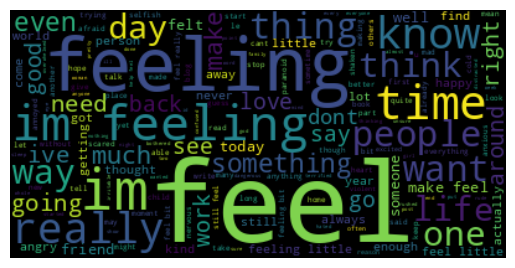

In [ ]:
# Wordcloud untuk Context

text_Context = " ".join(i for i in df['Comment'])

wordcloud = WordCloud().generate(text_Context)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

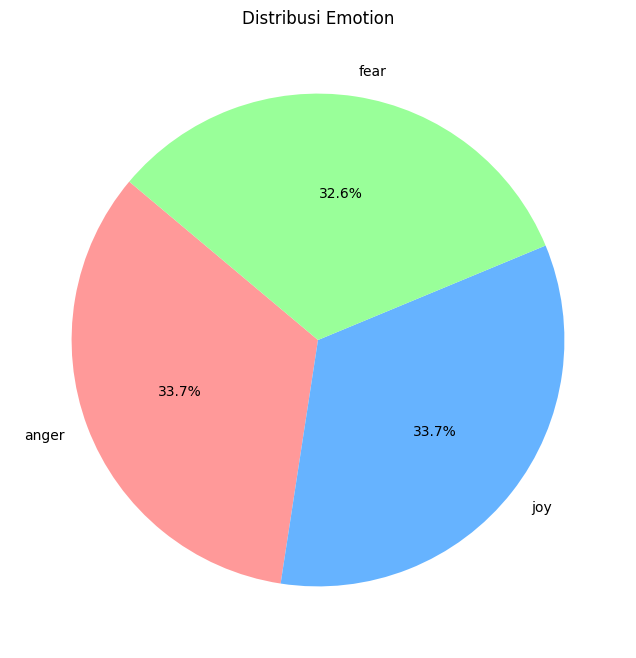

In [ ]:
# Visualisasi Emotion

# Menghitung frekuensi masing-masing emosi
emotion_counts = df['Emotion'].value_counts()

# Membuat pie chart
plt.figure(figsize=(8, 8))
plt.pie(emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])

# Menambahkan judul
plt.title('Distribusi Emotion')

# Menampilkan plot
plt.show()

# Splitting Data

In [ ]:
# Fitur dan Label
X = X_vect
y = df['Emotion']

# Pembagian Data untuk Pelatihan dan Pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pembuatan Model

## Naive Bayes

In [ ]:
# Model Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Probabilitas prediksi
nb_probs = nb_model.predict_proba(X_test)

# Menghitung ROC AUC
nb_auc = roc_auc_score(y_test, nb_probs, multi_class='ovr')

print("Naive Bayes:")
print(f"Accuracy: {accuracy_score(y_test, nb_model.predict(X_test)):.2f}")
print(f"ROC AUC: {nb_auc:.2f}")
print("Classification Report:")
print(classification_report(y_test, nb_model.predict(X_test)))


Naive Bayes:
Accuracy: 0.90
ROC AUC: 0.98
Classification Report:
              precision    recall  f1-score   support

       anger       0.88      0.92      0.90       392
        fear       0.91      0.92      0.91       416
         joy       0.93      0.87      0.90       380

    accuracy                           0.90      1188
   macro avg       0.91      0.90      0.90      1188
weighted avg       0.91      0.90      0.90      1188



## Logistic Regression

In [ ]:
# Model Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Probabilitas prediksi
lr_probs = lr_model.predict_proba(X_test)

# Menghitung ROC AUC
lr_auc = roc_auc_score(y_test, lr_probs, multi_class='ovr')

print("Logistic Regression:")
print(f"Accuracy: {accuracy_score(y_test, lr_model.predict(X_test)):.2f}")
print(f"ROC AUC: {lr_auc:.2f}")
print("Classification Report:")
print(classification_report(y_test, lr_model.predict(X_test)))


Logistic Regression:
Accuracy: 0.94
ROC AUC: 0.99
Classification Report:
              precision    recall  f1-score   support

       anger       0.94      0.93      0.94       392
        fear       0.96      0.91      0.94       416
         joy       0.91      0.97      0.94       380

    accuracy                           0.94      1188
   macro avg       0.94      0.94      0.94      1188
weighted avg       0.94      0.94      0.94      1188



## Random Forest

In [ ]:
# Model Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Probabilitas prediksi
rf_probs = rf_model.predict_proba(X_test)

# Menghitung ROC AUC
rf_auc = roc_auc_score(y_test, rf_probs, multi_class='ovr')

print("Random Forest:")
print(f"Accuracy: {accuracy_score(y_test, rf_model.predict(X_test)):.2f}")
print(f"ROC AUC: {rf_auc:.2f}")
print("Classification Report:")
print(classification_report(y_test, rf_model.predict(X_test)))


Random Forest:
Accuracy: 0.95
ROC AUC: 0.99
Classification Report:
              precision    recall  f1-score   support

       anger       0.93      0.94      0.94       392
        fear       0.96      0.94      0.95       416
         joy       0.96      0.97      0.97       380

    accuracy                           0.95      1188
   macro avg       0.95      0.95      0.95      1188
weighted avg       0.95      0.95      0.95      1188



## Neural Network

In [ ]:
# Model Neural Network
nn_model = MLPClassifier(max_iter=1000)
nn_model.fit(X_train, y_train)

# Probabilitas prediksi
nn_probs = nn_model.predict_proba(X_test)

# Menghitung ROC AUC
nn_auc = roc_auc_score(y_test, nn_probs, multi_class='ovr')

print("Neural Network:")
print(f"Accuracy: {accuracy_score(y_test, nn_model.predict(X_test)):.2f}")
print(f"ROC AUC: {nn_auc:.2f}")
print("Classification Report:")
print(classification_report(y_test, nn_model.predict(X_test)))


Neural Network:
Accuracy: 0.89
ROC AUC: 0.98
Classification Report:
              precision    recall  f1-score   support

       anger       0.89      0.88      0.89       392
        fear       0.88      0.89      0.88       416
         joy       0.89      0.88      0.89       380

    accuracy                           0.89      1188
   macro avg       0.89      0.89      0.89      1188
weighted avg       0.89      0.89      0.89      1188

